In [1]:
### This block is mainly for Google Colab

# try:
#     from Bio import SeqIO, AlignIO
# except:
#     !pip install biopython
#     from Bio import SeqIO, AlignIO

# try:
#     import torch
# except:
#     !pip install torch
#     import torch

# try:
#   import pytorch_lightning as pl
# except:
#   !pip install pytorch-lightning
#   import pytorch_lightning as pl

In [2]:
import os
import numpy as np
import pandas as pd
import gzip
import matplotlib.pyplot as plt

import torch
from Bio import SeqIO, AlignIO

import warnings
# warnings.filterwarnings('ignore')

# np.set_printoptions(threshold=np.inf, linewidth=np.inf)
np.set_printoptions(threshold=100)
torch.set_printoptions(edgeitems=10)

/tmp/ipykernel_138525/2106770942.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
if not os.path.exists('./data/PF00144_full_labeled.fasta'):
    !wget --no-check-certificate -O ./data/PF00144_full_labeled.fasta https://sid.erda.dk/share_redirect/a5PTfl88w0/PF00144_full_labeled.fasta
if not os.path.exists('./data/PF00042.alignment.full.gz'):
    !wget --no-check-certificate -O ./data/PF00042.alignment.full.gz https://www.ebi.ac.uk/interpro/wwwapi//entry/pfam/PF00042/?annotation=alignment:full\&download

In [4]:
aa1_to_index = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6,
                'I': 7, 'K': 8, 'L': 9, 'M': 10, 'N': 11, 'P': 12,
                'Q': 13, 'R': 14, 'S': 15, 'T': 16, 'V': 17, 'W': 18,
                'Y': 19, 'X':20, 'Z': 21, '-': 22, 'B': 23}
# aa1 = "ACDEFGHIKLMNPQRSTVWYXZ-B"
MAX_INDEX = 20  # NUM_CLASSES = MAX_INDEX + 1
GAP_INDEX = MAX_INDEX
GAP_THRESHOLD = 0.99
SIMILARITY_THRESHOLD = 0.9
SIMILARITY_THRESHOLDS =[0.2, 0.4, 0.6, 0.8]

BATCH_SIZE = 64 

In [5]:
def numeric_encode(seq, max_index=None):
    seq_numeric = np.array([aa1_to_index[aa] for aa in str(seq).upper().replace('.', '-')])
    if max_index is not None:
        seq_numeric[seq_numeric > max_index] = max_index
    return torch.from_numpy(seq_numeric)


def filter_gaps(index_seqs, gap_index, threshold=0.9):
    N = index_seqs.shape[0]
    gap_pos = torch.sum(index_seqs == gap_index, dim=0) > threshold * N
    filtered_sequences = index_seqs[:, ~gap_pos]
    return filtered_sequences


def calculate_similarity_matrix(index_seqs, num_classes):
    N = len(index_seqs)
    L = len(index_seqs[0])
    C = num_classes
    # index_seqs = torch.tensor(index_seqs)
    one_hot_seqs = torch.nn.functional.one_hot(index_seqs, num_classes=C)
    one_hot_seqs[index_seqs > 19] = 0
    seq_lengths = (index_seqs <= 19).sum(dim=1).unsqueeze(-1)
    flat_one_hot_seqs = one_hot_seqs.view(N, L*C)
    similarity_matrix = torch.mm(flat_one_hot_seqs.float(),
                                 flat_one_hot_seqs.float().t()) / seq_lengths
    return similarity_matrix


def calculate_weights(similarity_matrix, similarity_thresholds):
    weights = {}
    for st in similarity_thresholds:
        w = 1.0 / similarity_matrix.gt(st).sum(dim=1).float()
        weights[str(st)] = w
    return weights


def filter_sequences(similarity_matrix, threshold=0.9):
    N = similarity_matrix.shape[0]
    keep_idx = []
    rm_idx = set()
    for i in range(0, N):
        if i not in rm_idx:
            keep_idx.append(i)
            sim_idx = torch.nonzero(similarity_matrix[i][i+1:] > threshold).flatten() + (i+1)
            rm_idx.update(set(sim_idx.tolist()))
    return keep_idx


test_index_seqs = torch.randint(0, 5, size=(15, 10))
test_similarity_matrix = calculate_similarity_matrix(test_index_seqs, 20)
filter_sequences(test_similarity_matrix, 0.5)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Pre-processing 

In [6]:
### File Loading

# input_file = './data/PF00144_full_labeled.fasta'
input_file = './data/PF00042.alignment.full.gz'

if input_file.endswith('.gz'):
    with gzip.open(input_file, 'rt') as handle:
        alignment = AlignIO.read(handle, "stockholm")
elif input_file.endswith('.fasta'):
    with open(input_file, 'r') as f:
        alignment = AlignIO.read(f, "fasta")

encoded_sequences = {}
for record in alignment:
    # encoded_sequences[record.id] = one_hot_encode(record.seq)
    encoded_sequences[record.id] = numeric_encode(record.seq, MAX_INDEX)

In [7]:
### Pre-processing (filtering)

index_seqs = torch.stack(list(encoded_sequences.values()))
print(f'Length of MSA: {len(index_seqs[0])}')
index_seqs = filter_gaps(index_seqs, GAP_INDEX, GAP_THRESHOLD)
print(f'Length of MSA after gap filtering: {len(index_seqs[0])}')
print(f'Number of seqs: {len(index_seqs)}')
similarity_matrix = calculate_similarity_matrix(index_seqs, MAX_INDEX+1)
keep_indicies = filter_sequences(similarity_matrix, SIMILARITY_THRESHOLD)
index_seqs = index_seqs[keep_indicies]
print(f'Number of seqs after similarity filtering: {len(index_seqs)}') # 8364
weights_dict = calculate_weights(similarity_matrix, SIMILARITY_THRESHOLDS)

Length of MSA: 613
Length of MSA after gap filtering: 166
Number of seqs: 17160
Number of seqs after similarity filtering: 8364


In [ ]:
# torch_file = './data/index_seqs.pt'
# torch.save(index_seqs, torch_file)
# index_seqs = torch.load(torch_file)

# Model 

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl


class VAE(pl.LightningModule):    
    def __init__(self, input_dim, device='cpu', h_params=None):
        super().__init__()
        self._device = device
        self.h_params = {
            'z_dim': 2,
            'lr': 1e-3,
            'dropout': 0.1,
            'beta': 0.01,
            'activation': nn.LeakyReLU,
            'encoder_dims': [1500, 1500],
            'decoder_dims': [100, 500]
        }
        if h_params is not None:
            self.h_params.update(h_params)
        self.save_hyperparameters(self.h_params)
        
        encoder_dims = self.h_params['encoder_dims']
        decoder_dims = self.h_params['decoder_dims']    
        z_dim = self.h_params['z_dim']

        # Build Encoder
        modules = []
        in_dim = input_dim
        for h_dim in encoder_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_dim, h_dim),
                    nn.Dropout(self.h_params['dropout']),
                    nn.BatchNorm1d(h_dim),
                    self.h_params['activation']())
            )
            in_dim = h_dim

        self.encoder = nn.Sequential(*modules)
        self.encoder_mu = nn.Linear(encoder_dims[-1], z_dim)
        self.encoder_log_var = nn.Linear(encoder_dims[-1], z_dim)

        # Build Decoder
        modules = []
        in_dim = z_dim
        for h_dim in decoder_dims:
            modules.append(
                nn.Sequential(
                    nn.Linear(in_dim, h_dim),
                    nn.Dropout(self.h_params['dropout']),
                    nn.BatchNorm1d(h_dim),
                    self.h_params['activation']())
            )
            in_dim = h_dim
        modules.append(
            nn.Sequential(
                nn.Linear(decoder_dims[-1], input_dim))
        )
        self.decoder = nn.Sequential(*modules)

        self.loss_fn = nn.CrossEntropyLoss(reduction='mean')

    def encode(self, x): # x: [N, L]
        x_one_hot = nn.functional.one_hot(x.long().to(self._device), MAX_INDEX+1).float() # [N, L, C]
        x_one_hot_flat = x_one_hot.reshape(x_one_hot.shape[0], -1) # [N, L*C]
        h = self.encoder(x_one_hot_flat)
        mu = self.encoder_mu(h)
        log_var = self.encoder_log_var(h)
        return mu, log_var

    def decode(self, z):
        h = self.decoder(z) # [N, L*C]
        N, LC = h.shape
        C = MAX_INDEX + 1
        L = LC // C
        h_reshaped = h.view(N, L, C)  # [N, L, C]
        h_softmax = torch.nn.functional.softmax(h_reshaped, dim=2)
        h_final = h_softmax.view(N, L*C) # [N, L*C]
        return h_final

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x, n_samples=1):
        mu, log_var = self.encode(x)
        z_samples = self.reparameterize(mu, log_var)
        x_recon = self.decode(z_samples)
        return x_recon, mu, log_var

    def _step(self, batch, batch_idx):
        x = batch.long() # [N, L]
        x_recon, mu, log_var = self(x) # x_recon: [N, L*C]
        N, L = x.shape
        C = x_recon.shape[1] // L
        x_recon = x_recon.view(N, L, C)
        x = x.view(-1) # [N*L]
        x_recon = x_recon.view(-1, C) # [N*L, C]
        x_recon_logigts = torch.log(x_recon+1e-6)
        recon_loss = self.loss_fn(x_recon_logigts, x)
        kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu**2 - log_var.exp(), dim=1), dim=0)
        kl_loss *= self.h_params['beta']
        loss = recon_loss + kl_loss
        # if torch.isnan(recon_loss) or torch.isnan(kl_loss):
        #     print(f'x: {x}')
        #     print(f'x_recon: {x_recon}')
        #     print(f'mu: {mu}, log_var: {log_var}')
        return loss, recon_loss, kl_loss

    def training_step(self, batch, batch_idx):
        loss, recon_loss, kl_loss = self._step(batch, batch_idx)
        self.log_dict(
            {'train_loss': loss,
             'recon_loss': recon_loss,
             'kl_loss': kl_loss},
            on_step=False, on_epoch=True)
        # print(f'\nrecon_loss: {recon_loss:.3f}, kl_loss: {kl_loss:.3e}')
        return loss

    def validation_step(self, batch, batch_idx):
        loss, recon_loss, kl_loss = self._step(batch, batch_idx)
        self.log_dict(
            {'val_loss': loss},
            on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        loss, recon_loss, kl_loss = self._step(batch, batch_idx)
        self.log_dict(
            {'test_loss': loss},
            on_step=False, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.h_params['lr'])


# x = torch.randn(4, 141*21)
x = torch.randint(low=0, high=21, size=(32, 141))
model_test = VAE(input_dim=141*21, device='cpu')
# model_test = model_test.to('cuda')

x_recon, mu, log_var = model_test(x)
print(f'x: {x.shape}')
print(f'x_recon: {x_recon.shape}')
print(f'mu: {mu.shape}')
print(f'log_var: {log_var.shape}')

# model_test = VAE(input_dim=141*21, device='cpu')
# x = torch.randint(low=0, high=21, size=(32, 141))
# mu, log_var = model_test.encode(x)
# z_samples = model_test.reparameterize(mu, log_var)
# x_recon = model_test.decode(z_samples)

x: torch.Size([32, 141])
x_recon: torch.Size([32, 2961])
mu: torch.Size([32, 2])
log_var: torch.Size([32, 2])


In [9]:
from pytorch_lightning.callbacks import TQDMProgressBar
from tqdm import tqdm

class CustomProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        """
        This method customizes the tqdm progress bar for validation.
        """
        # Create a simple progress bar with minimal information
        bar = tqdm(
            desc='Validation',
            total=None,  # Total will be unknown; the bar will show as a simple spinner
            leave=True,  # Leave the progress bar displayed after validation is complete
            position=0,
            disable=self.is_disabled,  # Disable if progress bars are globally disabled
            dynamic_ncols=True,  # Adjust to the terminal window width
            smoothing=0  # Disable smoothing for more responsive updates
        )
        return bar

In [10]:
full_dataset = index_seqs


total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
seed = torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size], generator=seed)


# Adding weights
train_indices = train_dataset.indices
train_weights = weights_dict['0.8'][train_indices]
train_sampler = torch.utils.data.WeightedRandomSampler(train_weights, num_samples=len(train_weights), replacement=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, shuffle=False)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)


for batch in train_loader:
    batch = batch.to('cuda')
for batch in valid_loader:
    batch = batch.to('cuda')

# Training

In [ ]:
N, L = index_seqs.shape
C = MAX_INDEX + 1

vae_model = VAE(input_dim=L*C, device='cuda')
vae_model = vae_model.to('cuda')
trainer = pl.Trainer(max_epochs=10, callbacks=[CustomProgressBar()])
trainer.fit(model=vae_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

In [ ]:
trainer.test(model=vae_model, dataloaders=test_loader)

# Hyperparameter Optimization

In [11]:
from itertools import product

In [35]:
n_epochs = 2
z_dim = 2
lr = 1e-3
dropouts = [0.1, 0.2, 0.5]
betas = [1e-3, 1e-2, 0.1, 0.3]
activations = [nn.LeakyReLU, nn.ReLU, nn.SELU, nn.ELU]


dropouts = [0.7, 0.2]
betas = [1e-3, 1e-2]
activations = [nn.LeakyReLU, nn.ReLU]

N, L = index_seqs.shape
C = MAX_INDEX + 1

for dropout, beta, activation in product(dropouts, betas, activations):
    h_params = {'lr': lr, 'dropout': dropout, 'activation': activation}
    print(h_params)
    vae_model = VAE(input_dim=L*C, device='cuda', h_params=h_params)
    vae_model = vae_model.to('cuda')
    trainer = pl.Trainer(max_epochs=n_epochs, callbacks=[CustomProgressBar()])
    trainer.fit(model=vae_model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
    break 

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params
-----------------------------------------------------
0 | encoder         | Sequential       | 7.5 M 
1 | encoder_mu      | Linear           | 3.0 K 
2 | encoder_log_var | Linear           | 3.0 K 
3 | decoder         | Sequential       | 1.8 M 
4 | loss_fn         | CrossEntropyLoss | 0     
-----------------------------------------------------
9.3 M     Trainable params
0         Non-trainable params
9.3 M     Total params
37.170    Total estimated model params size (MB)


{'lr': 0.001, 'dropout': 0.7, 'activation': <class 'torch.nn.modules.activation.LeakyReLU'>}
Epoch 0: 100%|█████████████████████████████| 92/92 [00:01<00:00, 53.47it/s, v_num=38]

Validation DataLoader 0: 100%|██████████████████████| 20/20 [00:00<00:00, 120.63it/s]

Epoch 0: 100%|█████████████████████████████| 92/92 [00:01<00:00, 48.41it/s, v_num=38]

Epoch 1: 100%|█████████████████████████████| 92/92 [00:01<00:00, 51.74it/s, v_num=38]

Validation DataLoader 0: 100%|██████████████████████| 20/20 [00:00<00:00, 121.80it/s]

Epoch 1: 100%|█████████████████████████████| 92/92 [00:01<00:00, 46.94it/s, v_num=38]


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|█████████████████████████████| 92/92 [00:02<00:00, 40.23it/s, v_num=38]


## Loading a trained model

In [ ]:
### Save the model
# from google.colab import drive
# drive.mount('/content/drive')

# model_path = "/content/drive/MyDrive/CSHL/Projects/vae_model_w08_0122.ckpt"
# trainer.save_checkpoint(model_path)

In [49]:
### Load the model
N, L = index_seqs.shape
C = MAX_INDEX + 1

ct = 71

model_path = f'./lightning_logs/version_{ct}/checkpoints/epoch=19-step=5980.ckpt'
h_params = hp_dir[ct]
vae_model = VAE.load_from_checkpoint(checkpoint_path=model_path, input_dim=L*C, h_params=h_params)

# Visualization

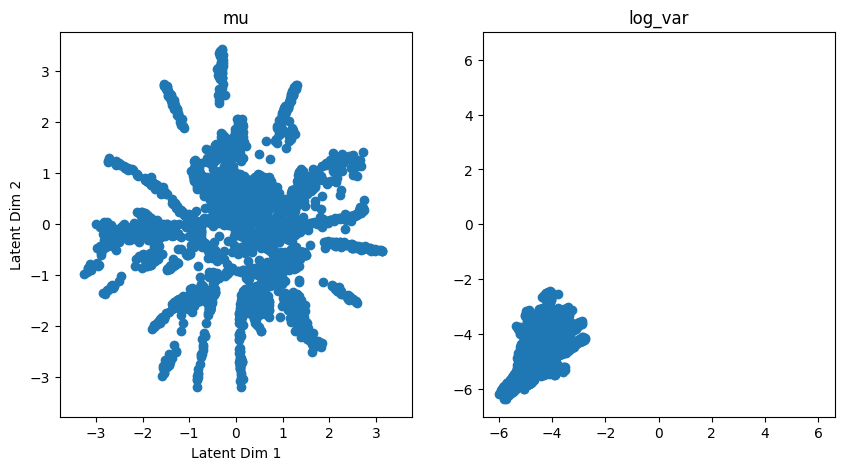

In [60]:
import matplotlib.pyplot as plt

vae_model.eval()
latents = []
vars = []
# labels = []
with torch.no_grad():
    for batch in valid_loader:
        mu, log_var = vae_model.encode(batch.long())
        latents.append(mu)
        vars.append(log_var)

latents = torch.cat(latents).cpu().numpy()
vars = torch.cat(vars).cpu().numpy()
# labels = torch.cat(labels).cpu().numpy()

fig, axs = plt.subplots(1, 2, figsize=[10, 5])
x_maxabs0 = np.max(np.abs(latents[:, 0]))*1.1
y_maxabs0 = np.max(np.abs(latents[:, 1]))*1.1

x_maxabs0 = np.max(np.abs(latents))*1.1
y_maxabs0 = x_maxabs0

x_maxabs1 = np.max(np.abs(vars[:, 0]))*1.1
y_maxabs1 = np.max(np.abs(vars[:, 1]))*1.1


axs[0].scatter(latents[:, 0], latents[:, 1])
axs[0].set_xlim(-x_maxabs0, x_maxabs0)
axs[0].set_ylim(-y_maxabs0, y_maxabs0 )
axs[0].set_xlabel('Latent Dim 1')
axs[0].set_ylabel('Latent Dim 2')
axs[0].set_title('mu')

# axs[1].scatter(latents[:, 2], latents[:, 3])
# axs[1].set_xlim(-x_maxabs0, x_maxabs0)
# axs[1].set_ylim(-y_maxabs0, y_maxabs0 )
# axs[1].set_xlabel('Latent Dim 3')
# axs[1].set_ylabel('Latent Dim 4')
# axs[1].set_title('mu')

axs[-1].scatter(vars[:, 0], vars[:, 1])
axs[-1].set_xlim(-x_maxabs1, x_maxabs1)
axs[-1].set_ylim(-y_maxabs1, y_maxabs1)
axs[-1].set_title('log_var')
# plt.xlabel('Latent Dim 1')
# plt.ylabel('Latent Dim 2')
plt.show()

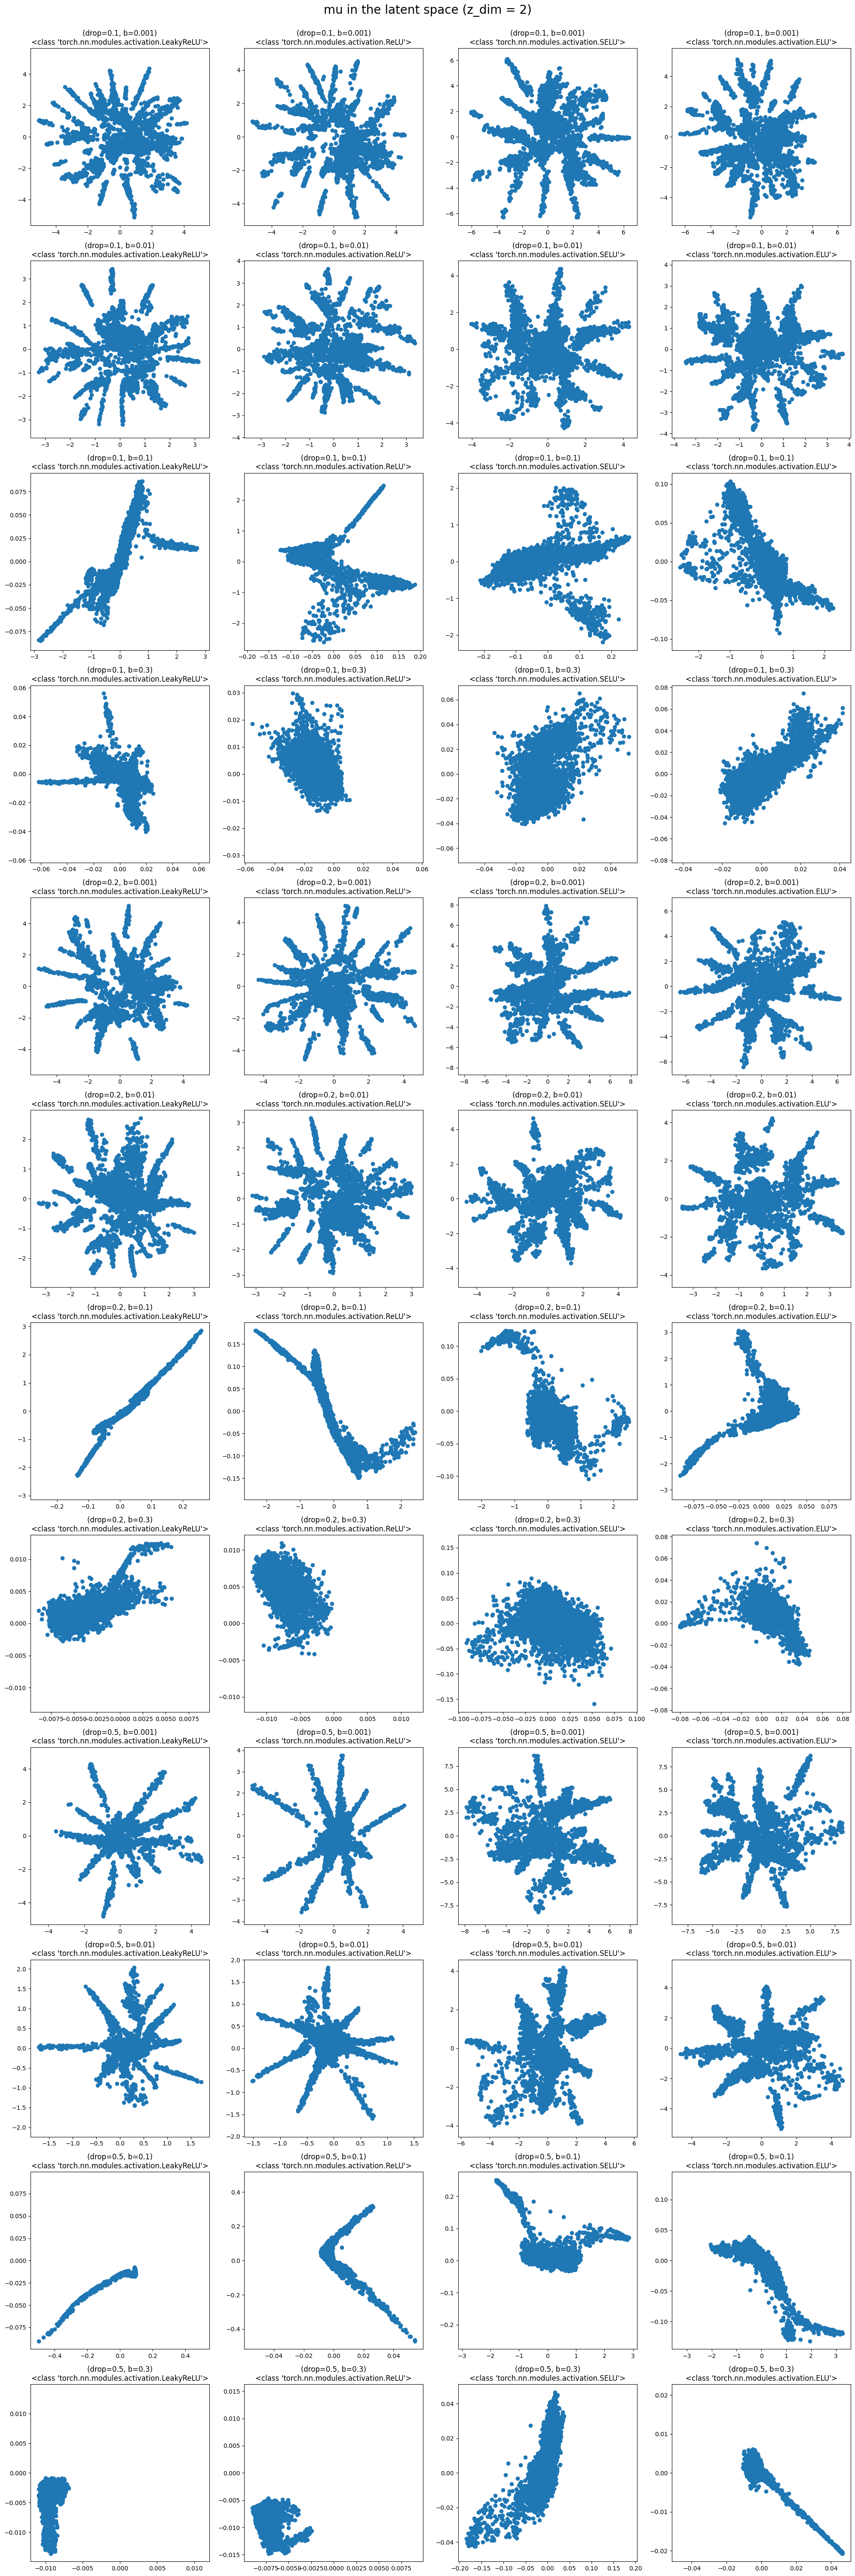

In [94]:
import matplotlib.pyplot as plt

n_rows = 12
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=[5 * n_cols, 5 * n_rows+3])
for i in range(0, 48):
    h_params = hp_dir[i+67]
    model_path = f'./lightning_logs/version_{i+67}/checkpoints/epoch=19-step=5980.ckpt'
    vae_model = VAE.load_from_checkpoint(checkpoint_path=model_path, input_dim=L*C, h_params=h_params)
    vae_model.eval()
    latents = []
    with torch.no_grad():
        for batch in valid_loader:
            mu, log_var = vae_model.encode(batch.long())
            latents.append(mu)
    latents = torch.cat(latents).cpu().numpy()
    x_maxabs0 = np.max(np.abs(latents[:, 0]))*1.1
    y_maxabs0 = np.max(np.abs(latents[:, 1]))*1.1
    ax = axs[i//4][i%4]
    ax.scatter(latents[:, 0], latents[:, 1])
    ax.set_xlim(-x_maxabs0, x_maxabs0)
    ax.set_ylim(-y_maxabs0, y_maxabs0 )
    dropout = h_params['dropout']
    beta = h_params['beta']
    activation = h_params['activation']
    ax.set_title(f'(drop={dropout}, b={beta})\n{activation}')
    if i == n_rows * n_cols - 1:
        break

plt.suptitle('mu in the latent space (z_dim = 2)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98]) 
plt.savefig('latents.pdf')
plt.show()